In [1]:
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mlflow

def get_metrics(mlflow_client, run_id, keys):

    rows = []

    for key in keys:
        items = mlflow_client.get_metric_history(run_id, key)
        items = map(dict, items)
        rows.extend(items)

    result = pd.DataFrame(rows)

    return result

In [3]:
mlflow_client = mlflow.tracking.MlflowClient(
    tracking_uri="http://localhost:5009",
)

In [4]:
run_id = "ca8ff65afb5744a2bde060f116d70a22"
experiment_name = "nn-classifier"

In [5]:
names = "top_2_accuracy", "loss"
suffix = "test", "train"

keys = []
for name, suffix in product(names, suffix):
    key = "_".join([name, suffix])
    keys.append(key)

metrics = get_metrics(mlflow_client, run_id, keys)

metrics = metrics.pivot(index="step", columns="key", values="value")

metrics.head()

key,loss_test,loss_train,top_2_accuracy_test,top_2_accuracy_train
step,,,,
0,0.013595,0.015550,0.676576,0.461813
1,0.009855,0.010523,0.751301,0.753474
2,0.008973,0.006739,0.822727,0.888808
3,0.006863,0.005255,0.869238,0.909950
4,0.006983,0.004158,0.852761,0.933284


In [6]:
epoch_best = metrics["top_2_accuracy_test"].idxmax()
epoch_best

9

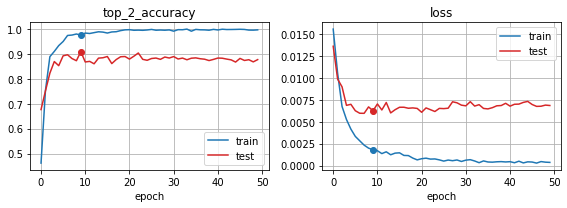

In [235]:
fig, axes = plt.subplots(ncols=len(names), figsize=(8, 3))

for key, ax in zip(names, axes):

    plt.sca(ax)

    train = metrics[f"{key}_train"]
    test = metrics[f"{key}_test"]

    color = "C0"
    plt.plot(train, label="train", color=color)
    plt.plot(epoch_best, train.loc[epoch_best], "o", color=color)

    color = "C3"
    plt.plot(test, label="test", color=color)
    plt.plot(epoch_best, test.loc[epoch_best], "o", color=color)

    plt.title(key)

    plt.legend()
    plt.xlabel("epoch")
    plt.grid()

plt.tight_layout()

plt.savefig(f"../images/learning-curves-{run_id}.png", facecolor="white", dpi=300)

In [241]:
# filename = "../reports/nn-classifier/data-026-d6b931c9dc6d4998858c8584db1e59bb.csv"
filename = "../mlruns/8/ca8ff65afb5744a2bde060f116d70a22/artifacts/predictions/data-009.csv"
df = pd.read_csv(filename, index_col=0)

df.head()

,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,emb_009,...,proba_true_photo,proba_pred_rococo,proba_true_rococo,label_code_pred,label_code_true,label_pred,label_true,x,y,z
1355,-1.966650,-4.499610,6.712947,4.555769,0.347537,0.236534,11.221177,-3.751014,13.279680,-4.332207,...,0.0,0.001199,0.0,0,0,artdeco,artdeco,10.019174,9.090077,9.430422
475,2.329449,-2.592850,14.024613,-1.253134,3.239005,-0.065436,7.013177,-4.491625,10.489229,-1.949365,...,0.0,0.008525,0.0,0,0,artdeco,artdeco,9.168530,10.507734,7.989253
466,-1.385862,-5.011714,8.924965,8.123796,1.149406,0.424730,9.949918,-3.934708,16.292060,-5.247743,...,0.0,0.000340,0.0,0,0,artdeco,artdeco,9.862047,8.941533,9.427500
450,-0.595890,-4.646506,5.037925,11.566640,-0.073167,2.385587,8.435506,-3.900283,17.392467,-4.086479,...,0.0,0.002803,0.0,0,0,artdeco,artdeco,10.013676,8.693975,9.046929
446,0.652303,-4.122998,6.781139,8.853655,1.048266,0.616448,6.892917,-3.661285,14.973774,-4.576105,...,0.0,0.002414,0.0,0,0,artdeco,artdeco,9.923131,8.859069,8.981589


In [242]:
from sklearn.metrics import classification_report, confusion_matrix

In [243]:
df_test = df[df.fold == "test"]

y_true = df_test["label_true"]
y_pred = df_test["label_pred"]

report = classification_report(y_true, y_pred)
print(report)

               precision    recall  f1-score   support

      artdeco       0.30      0.70      0.42        10
      cartoon       0.92      0.67      0.77        18
       cubism       0.91      0.80      0.85        85
impressionism       0.83      0.70      0.76        61
     japonism       0.65      0.81      0.72        57
   naturalism       0.71      0.64      0.67        61
        photo       0.88      0.91      0.90        33
       rococo       0.83      0.87      0.85        46

     accuracy                           0.77       371
    macro avg       0.75      0.76      0.74       371
 weighted avg       0.79      0.77      0.78       371



In [244]:
import sys
sys.path.append("../src")

from utils.visualization import plot_confusion_matrix

In [245]:
filename = "../data/code2label.yml"
code2label = pd.read_csv(filename, sep=":", index_col=0, header=None).iloc[:, -1]
code2label

0
0           artdeco
1           cartoon
2            cubism
3     impressionism
4          japonism
5        naturalism
6             photo
7            rococo
Name: 1, dtype: object

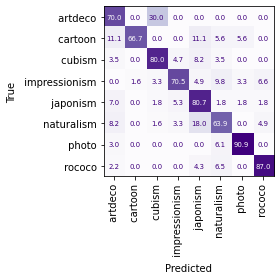

In [246]:
m = confusion_matrix(y_true, y_pred)

m = (m * 100 / m.sum(axis=1, keepdims=True)).round(1)

fig, ax = plt.subplots()
fig, ax = plot_confusion_matrix(
    m,
    cmap="Purples",
    labels=code2label,
    xticks_rotation="vertical",
    ax=ax
)
plt.sca(ax)

plt.tight_layout()

filename_save = f"../images/confmat-{run_id}.png"
plt.savefig(filename_save, facecolor="white", dpi=300)

# Recover model

In [7]:
import numpy as np
import pandas as pd
import yaml
import os
import torch
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm

import sys
sys.path.append("../src")

from datasets import PaintingDataset
from utils import load_config, rescale, load_resnet
from scorers import ScorerCombo as Scorer
from models import NNClassifier, Embedder

In [8]:
filename_config = "../params.yaml"
config = load_config(filename_config)

In [9]:
import mlflow

mlflow_experiment = "train_nn_classifier"
# run_id = "02d19b0502a84e18b4d45112770cde25"
# run_id = "7f77680bdbd340638561ea3f5f945fb6"
# run_id = "f33a7cc06c914092a709e2c509ed125d"  # CE only

mlflow_tracking_uri = config["shared"]["mlflow_tracking_uri"]
mlflow.set_tracking_uri(mlflow_tracking_uri)

experiment = mlflow.get_experiment_by_name(mlflow_experiment)

artifact_storage = os.path.join(
    "../",
    experiment.artifact_location,
    run_id,
    "artifacts"
)

print(artifact_storage)

.././mlruns/8/ca8ff65afb5744a2bde060f116d70a22/artifacts


In [10]:
def download_artifact_yaml(artifact_uri):

    filename = mlflow.artifacts.download_artifacts(artifact_uri)

    with open(filename) as f:
        artifact = yaml.safe_load(f)

    return artifact

In [11]:
artifact_uri = os.path.join(artifact_storage, "config-runtime.yaml")

config = download_artifact_yaml(artifact_uri)

In [12]:
config[mlflow_experiment]

{'batch_size': 32,
 'column_fold': 'fold_author',
 'device': 'mps',
 'filename_design': 'data/design.csv',
 'folder_images': 'data/raw/images',
 'folder_output_model': '/Users/andrey/Work/projects/BG-IML/models/train_nn_classifier/best',
 'folder_output_report': '/Users/andrey/Work/projects/BG-IML/reports/train_nn_classifier/best',
 'folds_use': [0, 1, 2, 3],
 'label_smoothing': 0.0,
 'mlflow_experiment': 'train_nn_classifier',
 'n_epochs': 50,
 'optimizer': {'lr': 0.0001, 'weight_decay': 0.0},
 'params_embedder': {'embedding_size': 16,
  'freeze_resnet_cnn': False,
  'freeze_resnet_fc': False,
  'resnet_name': 'resnet18'},
 'save_model_checkpoints': True,
 'scheduler': {'lr_final': 1e-05},
 'score_target': 'top_2_accuracy',
 'top_k_list': [1, 2, 3]}

# Load data

In [13]:
model_name = config["train_nn_classifier"]["params_embedder"]["resnet_name"]
_, resnet_weights = load_resnet(model_name)
transform_resnet = resnet_weights.DEFAULT.transforms()

In [14]:
ann = pd.read_csv("../data/design.csv")
folder_images = "../data/raw/images/"

dataset = PaintingDataset(ann, folder_images, transform_preprocess=transform_resnet)

100%|██████████| 1422/1422 [00:03<00:00, 397.88it/s]


In [15]:
artifact_uri = os.path.join(artifact_storage, "label_weight.yml")
label_weight = pd.Series(download_artifact_yaml(artifact_uri))

artifact_uri = os.path.join(artifact_storage, "code2label.yml")
code2label = pd.Series(download_artifact_yaml(artifact_uri))

In [16]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_tracking_uri)

In [17]:
mlflow_run = mlflow_client.get_run(run_id)

In [18]:
params = mlflow_run.data.params
params

{'weight': "tensor([0.0192, 0.0189, 0.0038, 0.0060, 0.0073, 0.0068, 0.0101, 0.0154],\n       device='mps:0')",
 'gamma': '0.954992586021436',
 'freeze_resnet_cnn': 'False',
 'n_epochs': '50',
 'embedding_size': '16',
 'resnet_name': 'resnet18',
 'top_k': '[1, 2, 3]',
 'optimizer': 'Adam',
 'label_smoothing': '0.0',
 'scheduler': 'ExponentialLR',
 'weight_decay': '0.0',
 'freeze_resnet_fc': 'False',
 'labels_use': 'all',
 'lr': '0.0001',
 'fold_index': '2',
 'n_classes': '8'}

# Load model

In [19]:
artifact_uri = os.path.join(artifact_storage, "model.st")
filename_model_st = mlflow.artifacts.download_artifacts(artifact_uri)

In [20]:
config["train_nn_classifier"]["params_embedder"]

{'embedding_size': 16,
 'freeze_resnet_cnn': False,
 'freeze_resnet_fc': False,
 'resnet_name': 'resnet18'}

In [21]:
model = NNClassifier(int(params["n_classes"]), config["train_nn_classifier"]["params_embedder"])
model.load_state_dict(torch.load(filename_model_st))
model.eval();

In [22]:
device = torch.device("mps")

In [23]:
model = model.to(device)

# Predict

In [24]:
Y_true = []
Y_pred = []
Z = []

with torch.no_grad():

    for i in tqdm(range(len(dataset))):

        x, y = dataset[i]

        x = x.unsqueeze(0).to(device)
        true = y.unsqueeze(0)
        pred, z = model(x)

        Y_pred.append(pred)
        Y_true.append(true)
        Z.append(z)

Z = torch.concat(Z).cpu()
Y_true = torch.concat(Y_true).cpu()
Y_pred = torch.concat(Y_pred).cpu()

  0%|          | 0/1422 [00:00<?, ?it/s]

In [25]:
features = pd.DataFrame(Z, columns=[f"emb_{i:02d}" for i in range(Z.shape[1])])

In [26]:
df = pd.concat([features, ann], axis=1)

proba_pred = torch.nn.functional.softmax(Y_pred, dim=1)
proba_true = torch.nn.functional.softmax(Y_true, dim=1)

for i, label in code2label.iteritems():
    key = f"proba_pred_{label}"
    df[key] = proba_pred[:, i]
    key = f"proba_true_{label}"
    df[key] = proba_true[:, i]

df["label_code_pred"] = Y_pred.argmax(dim=1)
df["label_code_true"] = Y_true.argmax(dim=1)

df["label_pred"] = df["label_code_pred"].replace(code2label)
df["label_true"] = df["label_code_true"].replace(code2label)

k = 3
proba_pred_topk, label_codes_pred_topk = torch.topk(proba_pred, k=k)

columns = [f"proba_pred_top_{i + 1}" for i in range(k)]
df_part = pd.DataFrame(proba_pred_topk, columns=columns)
df = pd.concat([df, df_part], axis=1)

columns = [f"label_code_pred_top_{i + 1}" for i in range(k)]
df_part = pd.DataFrame(label_codes_pred_topk, columns=columns)
df = pd.concat([df, df_part], axis=1)


for i in range(k):
    c = f"label_pred_top_{i + 1}"
    c_from = f"label_code_pred_top_{i + 1}"
    df[c] = df[c_from].replace(code2label)

In [27]:
fold_test = params["fold_index"]
fold_test

'2'

In [29]:
folds = ["0", "1", "3"], ["2"], ["val"]
names = "train", "test", "val"

scores = []

for fold, name in zip(folds, names):

    mask = df.fold_author.isin(fold)
    score = scorer(Y_pred[mask], Y_true[mask], Z[mask])
    score["name"] = name
    scores.append(score)

NameError: name 'scorer' is not defined

In [ ]:
print(
    pd.DataFrame(scores).round(2).set_index("name").to_string()
)

       precision  recall  fscore  top_1_accuracy  top_2_accuracy  silhouette_pred  davies_bouldin_pred  calinski_harabasz_pred  silhouette_true  davies_bouldin_true  calinski_harabasz_true
name                                                                                                                                                                                        
train       0.96    0.96    0.96            0.97            0.99             0.46                 0.75                  509.65             0.46                 0.76                  518.19
test        0.79    0.77    0.77            0.76            0.91             0.27                 1.14                   96.90             0.18                 1.34                   66.96
val         0.63    0.62    0.61            0.63            0.80             0.20                 1.23                   16.86             0.05                 2.03                    8.70


In [ ]:
filename_predictions_save = "../data/predictions/combo.csv"
# df.to_csv(filename_predictions_save, index=False)

# Draw examples

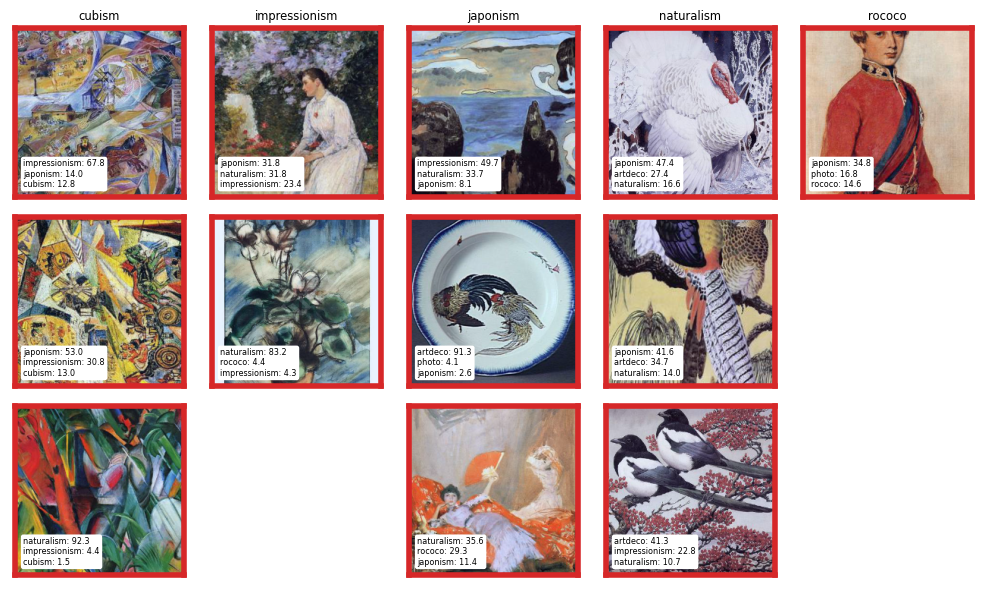

In [218]:
nrows = 3
scale = 2

mask_test = df.fold_author == fold_test

k = 3
column = f"label_pred_top_{k}"
filename_save = f"../images/prediction-examples-top-{k}-{run_id}.png"
mask_top = df.label_true == df[column]

mask_wrong = (df.label_true != df.label_pred_top_1) & (df.label_true != df.label_pred_top_2)
filename_save = f"../images/prediction-examples-wrong-{run_id}.png"

df_test = df.loc[mask_test & mask_top]

np.random.seed(0)

labels_unique = sorted(df_test.label.unique())
ncols = len(labels_unique)
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows * scale), dpi=100
)

for axes_col, label in zip(axes.T, labels_unique):

    indices_label = np.where(np.asarray(df_test.label) == label)[0]
    indices_label = df_test.index[indices_label]
    nrows_label = min(len(indices_label), nrows)
    indices = np.random.choice(indices_label, nrows_label, replace=False)

    for i in range(len(indices), len(axes_col)):
        axes_col[i].set_visible(False)

    for i, ax in zip(indices, axes_col):

        x, y = dataset[i]
        x = x.to(device)

        with torch.no_grad():
            y_pred, embedding = model(x.unsqueeze(0))

        y_pred = y_pred.squeeze().cpu()
        probas = torch.nn.functional.softmax(y_pred, dim=0)
        _, label_codes_pred = torch.topk(y_pred, k=3)
        label_codes_pred = label_codes_pred.numpy()
        probas_pred = probas[label_codes_pred].numpy()

        labels_pred = [code2label[i] for i in label_codes_pred]
        x_draw = rescale(x.cpu().permute(1, 2, 0))

        plt.sca(ax)

        plt.imshow(x_draw)

        lines = []
        for label_pred, proba_pred in zip(labels_pred, probas_pred):
            p = np.round(proba_pred * 100, 1)
            line = f"{label_pred}: {p}"
            lines.append(line)

        title = "\n".join(lines)

        bbox = dict(
            boxstyle="round",
            ec="none",
            fc="white",
        )

        plt.text(
            0.05,
            0.05,
            title,
            ha="left",
            va="bottom",
            transform=ax.transAxes,
            color="k",
            size="xx-small",
            bbox=bbox
        )

        if ax.get_subplotspec().is_first_row():
            plt.title(label, size="small")

        plt.xticks([])
        plt.yticks([])

        for spine in ax.spines.values():

            if label == labels_pred[0]:
                spine.set_visible(False)
                continue

            if label == labels_pred[1]:
                spine.set_linewidth(4)
                spine.set_edgecolor("C1")

            else:
                spine.set_linewidth(4)
                spine.set_edgecolor("C3")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()

plt.savefig(filename_save, facecolor="white", dpi=100)

# Occlusion

In [167]:
from torchvision.transforms import Grayscale
grayscale = Grayscale(num_output_channels=3)

In [187]:
x, y = dataset[90]

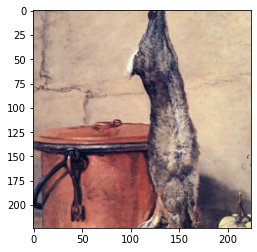

In [188]:
x_draw = rescale(x.cpu().permute(1, 2, 0))
plt.imshow(x_draw)

In [189]:
def calculate_occlusion(model, x, stride=16):
    
    mask_occlusion = torch.ones_like(x)

    with torch.no_grad():
        y_pred_intact, _ = model(x.to(device).unsqueeze(0))

    y_pred_intact = y_pred_intact.squeeze().cpu()
    n_classes = len(y_pred_intact)
    y_pred_intact = y_pred_intact.reshape(n_classes, 1, 1)


    result = torch.zeros(n_classes, x.shape[1], x.shape[2])
    result[:] = y_pred_intact

    indices_i = np.arange(0, mask_occlusion.shape[1] - stride + 1, stride)
    indices_j = np.arange(0, mask_occlusion.shape[2] - stride + 1, stride)

    for i in indices_i:
        for j in indices_j:
            mask_occlusion[:] = 1
            mask_occlusion[:, i: i+stride, j: j+stride] = 0

            x_occluded = mask_occlusion * x

            with torch.no_grad():
                y_pred, _ = model(x_occluded.to(device).unsqueeze(0))

            y_pred = y_pred.reshape(n_classes, 1, 1)

            result[:, i: i+stride, j: j+stride] = y_pred.clone()


    result = torch.nn.functional.softmax(result, dim=0)
    
    y_pred_intact = torch.nn.functional.softmax(y_pred_intact, dim=0)

    result = result - y_pred_intact # ) / y_pred_intact

    return result

In [190]:
idx = y.argmax()
idx

tensor(7)

In [194]:
occlusion = calculate_occlusion(model, x, stride=56 // 2).numpy()

In [195]:
occlusion_class = occlusion[idx]

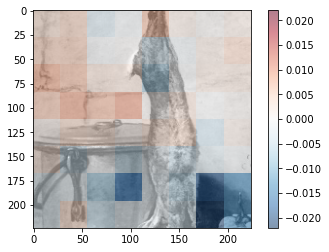

In [196]:
x_draw = rescale(grayscale(x).cpu().permute(1, 2, 0))
plt.imshow(x_draw)

vmax = np.abs(occlusion_class).max()

plt.imshow(
    occlusion_class,
    alpha=0.5,
    vmin=-vmax,
    vmax=vmax,
    cmap="RdBu_r",
    interpolation="none"
)

plt.colorbar()


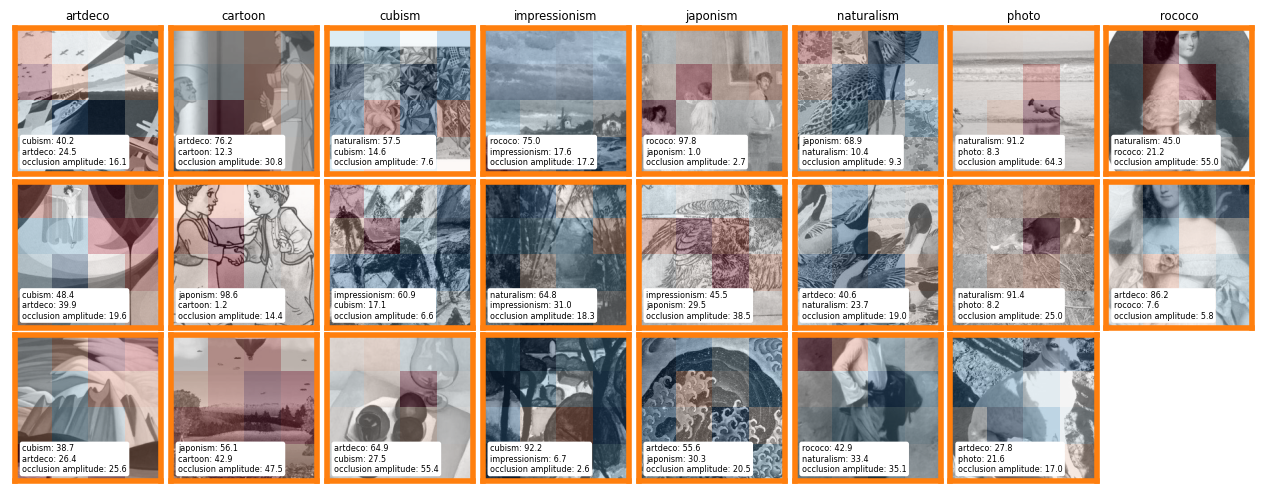

In [212]:
from torch import embedding


nrows = 3
n_classes = 8
ncols = n_classes
scale = 2

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(ncols * scale, nrows * scale), dpi=100
)

mask_test = df.fold_author == fold_test

k = 2
column = f"label_pred_top_{k}"
filename_save = f"../images/occlusion-top-{k}-{run_id}.png"
mask_top = df.label_true == df[column]

# mask_wrong = (df.label_true != df.label_pred_top_1) & (df.label_true != df.label_pred_top_2)
# filename_save = f"../images/occlusion-wrong-{run_id}.png"

df_test = df.loc[mask_test & mask_top]

np.random.seed(0)

labels_unique = sorted(df.label.unique())

for axes_col, label in zip(axes.T, labels_unique):

    indices_label = np.where(np.asarray(df_test.label) == label)[0]
    indices_label = df_test.index[indices_label]
    nrows_label = min(len(indices_label), nrows)
    indices = np.random.choice(indices_label, nrows_label, replace=False)

    for i in range(len(indices), len(axes_col)):
        axes_col[i].set_visible(False)

    for i, ax in zip(indices, axes_col):

        x, y = dataset[i]

        with torch.no_grad():
            y_pred, embedding = model(x.to(device).unsqueeze(0))

        y_pred = y_pred.squeeze().cpu()
        probas = torch.nn.functional.softmax(y_pred, dim=0)
        _, label_codes_pred = torch.topk(y_pred, k=3)
        label_codes_pred = label_codes_pred.numpy()
        probas_pred = probas[label_codes_pred].numpy()

        labels_pred = [code2label[i] for i in label_codes_pred]
        x_draw = rescale(x.cpu().permute(1, 2, 0))

        plt.sca(ax)

        # plt.imshow(x_draw)

        occlusion = calculate_occlusion(model, x, stride=56).numpy()
        occlusion_class = occlusion[y.argmax()]

        x_draw = rescale(grayscale(x).cpu().permute(1, 2, 0))
        plt.imshow(x_draw)

        vmax = np.abs(occlusion_class).max()

        plt.imshow(
            occlusion_class,
            alpha=0.3,
            vmin=-vmax,
            vmax=vmax,
            cmap="RdBu_r",
            interpolation="none"
        )

        # plt.colorbar()

        lines = []
        for label_pred, proba_pred in zip(labels_pred[:-1], probas_pred):
            p = np.round(proba_pred * 100, 1)
            line = f"{label_pred}: {p}"
            lines.append(line)

        line = f"occlusion amplitude: {np.round(vmax * 100, 1)}"
        lines.append(line)

        title = "\n".join(lines)

        bbox = dict(
            boxstyle="round",
            ec="none",
            fc="white",
        )

        plt.text(
            0.05,
            0.05,
            title,
            ha="left",
            va="bottom",
            transform=ax.transAxes,
            color="k",
            size="xx-small",
            bbox=bbox
        )

        if ax.get_subplotspec().is_first_row():
            plt.title(label, size="small")

        plt.xticks([])
        plt.yticks([])

        for spine in ax.spines.values():

            if label == labels_pred[0]:
                spine.set_visible(False)
                continue

            if label == labels_pred[1]:
                spine.set_linewidth(4)
                spine.set_edgecolor("C1")

            else:
                spine.set_linewidth(4)
                spine.set_edgecolor("C3")

plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.tight_layout()

plt.savefig(filename_save, facecolor="white", dpi=100, bbox_inches="tight")